# Pytorch model
<pre>
 Copyright (c) 2024 Aydin Hamedi
 
 This software is released under the MIT License.
 https://opensource.org/licenses/MIT
</pre>

## Pre Conf

In [1]:
CPU_only = False  # True to Force Pytorch to use the cpu

## Pylibs

In [6]:

import os
import torch
import pickle
import numpy as np
from torch import nn
from tqdm import tqdm
from numba import cuda
import matplotlib.pyplot as plt
from numba.cuda.cudadrv import enums
from torch.nn.functional import one_hot
from efficientnet_pytorch import EfficientNet
from torchvision import datasets, transforms


# Utils
from Utils.Other import *
from Utils.Grad_cam import *
from Utils.Debug import P_Debug
from Utils.print_color_V2_NEW import print_Color_V2
from Utils.print_color_V1_OLD import print_Color

## Prep

In [3]:
# Get the current device info >>>
device_C = cuda.get_current_device()
attribs = [name.replace("CU_DEVICE_ATTRIBUTE_", "") for name in dir(enums) if name.startswith("CU_DEVICE_ATTRIBUTE_")]

with open("GPU_Info.txt", "w") as f:
    for attr in attribs:
        f.write(f"{attr} = {getattr(device_C, attr)}\n")
# Get the current device for torch >>>
device = torch.device("cuda" if torch.cuda.is_available() and not CPU_only else "cpu")
print(f"Chosen device: {device}")
if device.type == 'cuda':
    device_name = torch.cuda.get_device_name(device)
    device_capability = torch.cuda.get_device_capability(device)
    print(f"CUDA | Device Name: {device_name}")
    print(f"CUDA | Device Capability: {device_capability}")

Chosen device: cuda
CUDA | Device Name: NVIDIA GeForce RTX 3090
CUDA | Device Capability: (8, 6)


## Conf


### Data processing conf

In [4]:
# Directory paths for training, test and validation image data >>>
# base |
train_dir = "Database\\Train\\Data\\train"
test_dir = "Database\\Train\\Data\\test"
validation_dir = "Database\\Train\\Data\\val"
# cache |
cache_dir = "Database\\cache"
# Image resolution
img_res = [224, 224, 3]
# Always Create dataset from base
dc_model = 0 # Dataset - Creation . Mode | 0 = Do not always | 1 = Always create from base


## data processing 


In [5]:
# Define a data transformer >>>
transform = transforms.Compose([
    transforms.Resize(img_res[:-1]),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert image to PyTorch Tensor data type
])
# Load the data to memory >>>
# Define a function to load the dataset
def load_dataset(directory, cache_dir, transform, dc_model):
    cache_file = os.path.join(cache_dir, os.path.basename(directory) + '.pkl')

    # Check if cache exists
    if os.path.exists(cache_file) and dc_model != 1:
        print_Color(f" |- ~*Loading cached data from: ~*{cache_file}", ['cyan', 'green'], advanced_mode=True)
        with open(cache_file, 'rb') as f:
            data, labels = pickle.load(f)
    else:
        print_Color(f" |- ~*Loading data from directory: ~*{directory}", ['cyan', 'green'], advanced_mode=True)
        dataset = datasets.ImageFolder(root=directory, transform=transform)
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=1)

        data, labels = [], []
        for image, label in tqdm(data_loader, desc=" |-- \x1b[0;36mLoading data\x1b[0m", unit="img"):
            data.append(image)
            labels.append(label)

        # Shuffle the data and labels
        print_Color(" |-- ~*Shuffling all batches...", ['cyan'], advanced_mode=True)
        indices = torch.randperm(len(data))
        data = [data[i] for i in indices]
        labels = [labels[i] for i in indices]
        
        print_Color(" |-- ~*Concatenate all batches...", ['cyan'], advanced_mode=True)
        data = torch.cat(data, 0)
        labels = torch.cat(labels, 0)

        # Cache the data and labels
        print_Color(f" |- ~*Caching data to: ~*{cache_file}", ['cyan', 'green'], advanced_mode=True)
        with open(cache_file, 'wb') as f:
            pickle.dump((data, labels), f)

    return data, labels
# Load the datasets
print_Color("Loading datasets...", ['yellow'])
print_Color(" | ~*Loading train...", ['cyan'], advanced_mode=True)
x_train, y_train = load_dataset(train_dir, cache_dir, transform, dc_model)
print_Color(" | ~*Loading test...", ['cyan'], advanced_mode=True)
x_test, y_test = load_dataset(test_dir, cache_dir, transform, dc_model)
print_Color(" | ~*Loading val...", ['cyan'], advanced_mode=True)
x_val, y_val = load_dataset(validation_dir, cache_dir, transform, dc_model)
# Convert labels to one-hot encoding
print_Color("One-hot encoding datasets...", ['yellow'])
y_train = one_hot(y_train, num_classes=2)
y_test = one_hot(y_test, num_classes=2)
y_val = one_hot(y_val, num_classes=2)
# End
print_Color("Done.", ['green'])

Loading datasets...
 | Loading train...
 |- Loading cached data from: Database\cache\train.pkl
 | Loading test...
 |- Loading cached data from: Database\cache\test.pkl
 | Loading val...
 |- Loading cached data from: Database\cache\val.pkl
One-hot encoding datasets...
Done.


## Data Analyzation

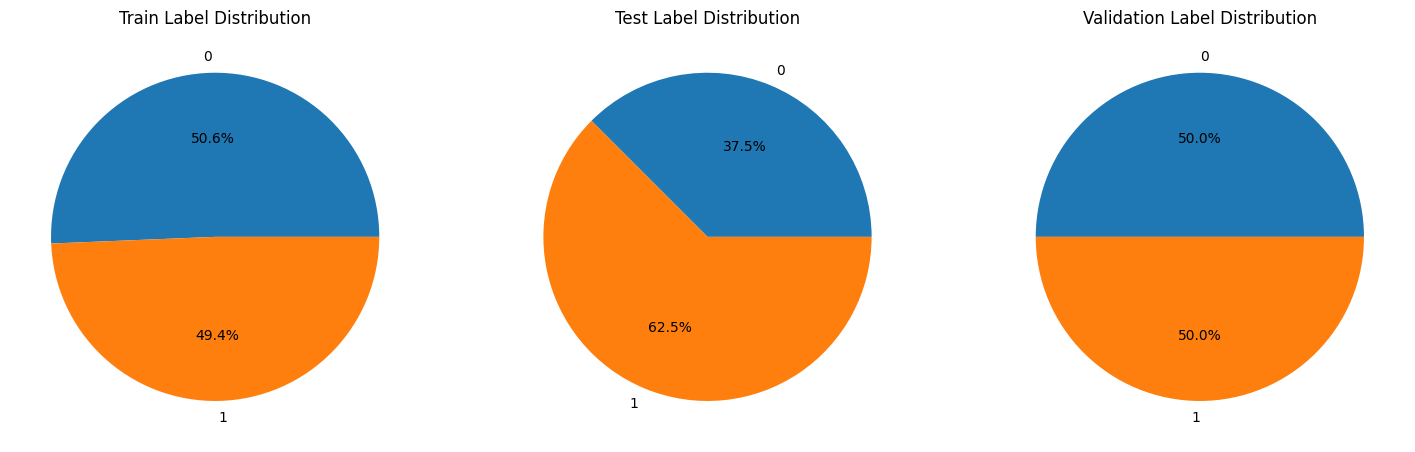

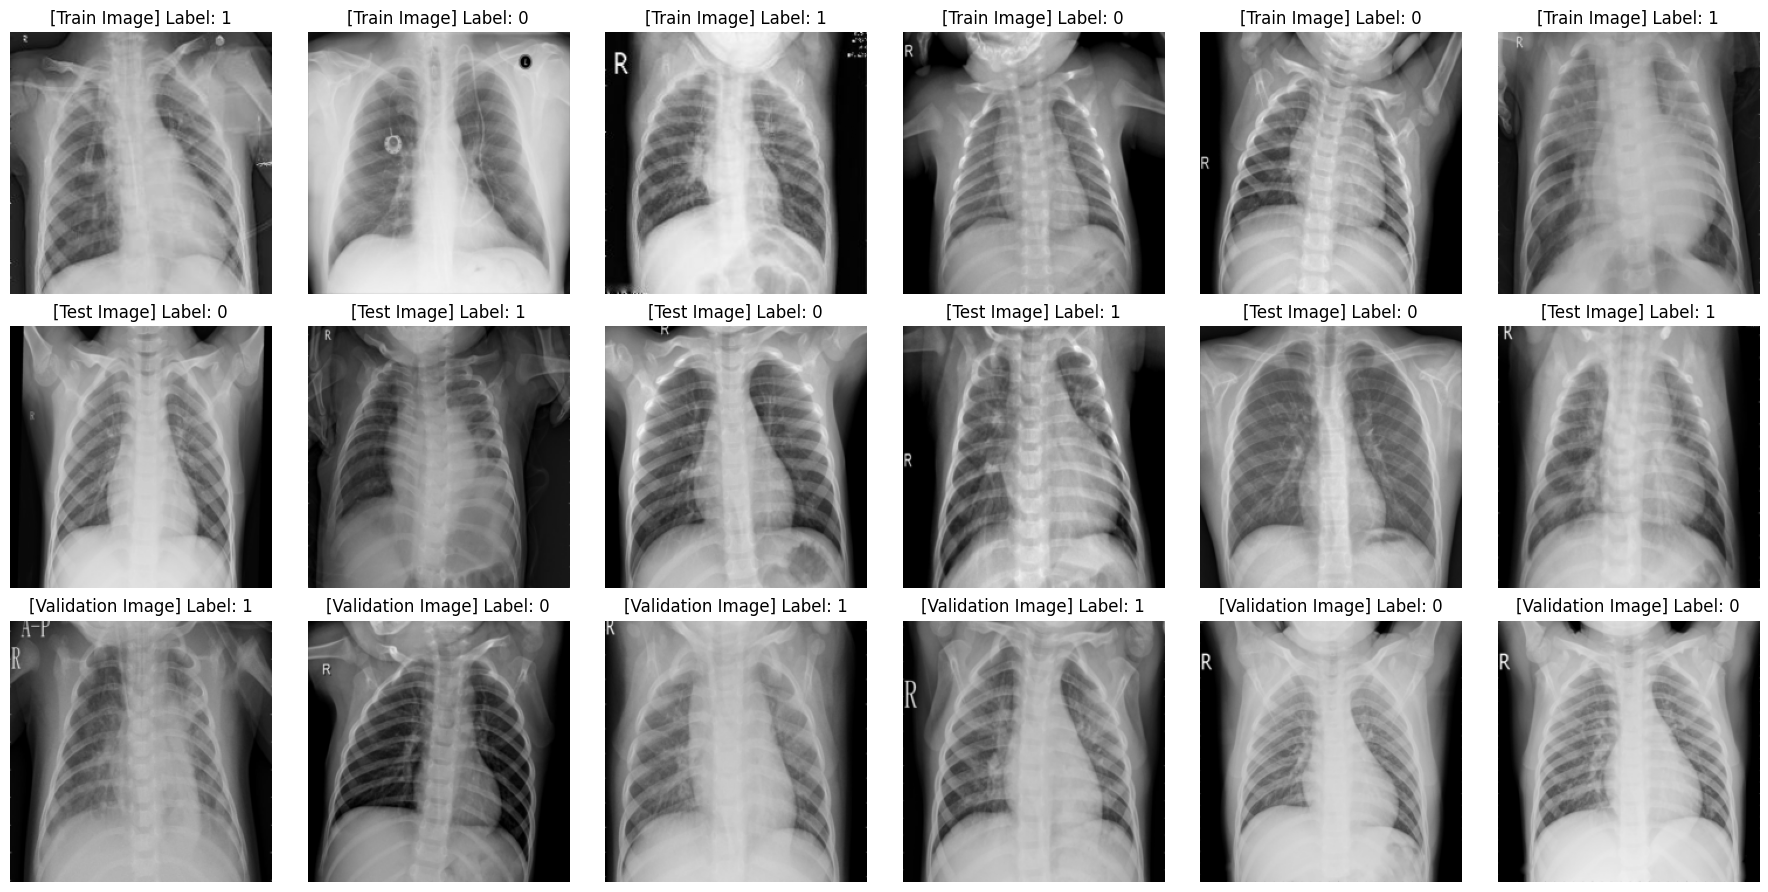

In [46]:
def plot_label_distribution(labels, title, subplot):
    unique_labels, counts = torch.unique(labels, return_counts=True)
    subplot.pie(counts, labels=unique_labels.tolist(), autopct='%1.1f%%')
    subplot.set_title(title)

def plot_example_images(images, labels, title, subplot):
    for i in range(6):
        subplot[i].imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
        subplot[i].set_title(f'[{title}] Label: {labels[i]}')
        subplot[i].axis('off')

# Create subplots for label distributions
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
plot_label_distribution(y_train.argmax(dim=1), 'Train Label Distribution', axs[0])
plot_label_distribution(y_test.argmax(dim=1), 'Test Label Distribution', axs[1])
plot_label_distribution(y_val.argmax(dim=1), 'Validation Label Distribution', axs[2])
plt.show()

# Create subplots for example images
fig, axs = plt.subplots(3, 6, figsize=(18, 9))
plot_example_images(x_train[:6], y_train.argmax(dim=1)[:6], 'Train Image', axs[0])
plot_example_images(x_test[:6], y_test.argmax(dim=1)[:6], 'Test Image', axs[1])
plot_example_images(x_val[:6], y_val.argmax(dim=1)[:6], 'Validation Image', axs[2])
plt.tight_layout()
plt.show()



## Creating the model


### Rev1 (Pytorch)
```
recommended: N/A
statuses: N/A
Working: N/A
Max fine tuned acc: ≅ N/A
type: transfer learning>>>(EfficientNetB0)
```

In [14]:
# Load pre-trained EfficientNet-B0
model = EfficientNet.from_pretrained('efficientnet-b0', include_top=True)

Loaded pretrained weights for efficientnet-b0


## Loading the model

## Training

#### Rev2
```
Working: ✅
Other:
 + Tensorboard works.
 + Perverts overfitting.
 + Lower memory usage.
 - Slow training.
 + Achieving higher acc.
 - Unstable training.
```

In [18]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

def train_model(model, x_train, y_train, x_test, y_test, epochs=10, batch_size=8):
    # Create data loaders
    train_data = TensorDataset(x_train, y_train)
    test_data = TensorDataset(x_test, y_test)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    # Define the optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Define the loss function
    criterion = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(epochs):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, torch.max(targets, 1)[1])
            loss.backward()
            optimizer.step()

        # Evaluation
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for inputs, targets in test_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == torch.max(targets, 1)[1]).sum().item()
            accuracy = 100 * correct / total
            print(f'Epoch {epoch+1}/{epochs}, Accuracy: {accuracy}%')

    return model
train_model(model, x_train, y_train, x_test, y_test, epochs=10, batch_size=8)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

## Saving model weights


In [ ]:
# Copyright (c) 2024 Aydin Hamedi
# 
# This software is released under the MIT License.
# https://opensource.org/licenses/MIT



## Garbage Collection (memory)

In [ ]:
import gc

# Garbage Collection (memory)
gc.collect()

## Release all the GPU memory

In [ ]:
from numba import cuda

device = cuda.get_current_device()
GPU_memUsage()  # noqa: F405
print("Realising all memory...")
device.reset()
GPU_memUsage()  # noqa: F405
print("done.")

## Analyse model Training performance

In [ ]:
# Save history
save_list(history, "history\\model_history.pkl.gz", compress=True)  # noqa: F405

In [ ]:
# load history
history = load_list("history\\model_history.pkl.gz", compressed=True)  # noqa: F405

In [ ]:
import matplotlib.pyplot as plt

# Chunk size for 3D plot
chunk_size = 6  # Change this to your desired chunk size


def convert_history(history):
    if isinstance(history, tf.keras.callbacks.History):
        return history.history
    else:
        return history


def chunked_data(data, chunk_size):
    return [data[i : i + chunk_size] for i in range(0, len(data), chunk_size)]


try:
    EPM = "Epoch(Subset)" if not isinstance(history, tf.keras.callbacks.History) else "Epoch"
    history = convert_history(history)

    # Calculate deltas
    delta_loss = np.diff(history["loss"])
    delta_accuracy = np.diff(history["accuracy"])

    try:
        delta_val_loss = np.diff(history["val_loss"])
        delta_val_accuracy = np.diff(history["val_accuracy"])
    except (ValueError, NameError):
        print("\033[91mfailed to load val_loss or val_accuracy for delta calculation.")

    plt.figure(figsize=(16, 10))
    # Loss
    plt.subplot(2, 2, 1)
    plt.plot(history["loss"], label="loss")
    try:
        plt.plot(history["val_loss"], label="val_loss", color="orange")
    except (ValueError, NameError):
        print("\033[91mfailed to load val_loss.")
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel(EPM)
    plt.ylim(top=max(history["val_loss"][10:]), bottom=0)  # (max(history['val_loss'][8:]) + min(history['val_loss'])) / 2
    plt.grid(True)

    # Density plot for loss
    plt.subplot(2, 2, 2)
    plt.hist(history["loss"], label="loss density", color="blue", alpha=0.5, bins=100)
    try:
        plt.hist(
            history["val_loss"],
            label="val_loss density",
            color="orange",
            alpha=0.5,
            bins=100,
        )
    except (ValueError, NameError):
        print("\033[91mfailed to load val_loss (density plot).")
    plt.title("Density Plot for Loss")
    plt.xlabel("Loss")
    plt.xlim(right=max(history["val_loss"][10:]), left=0)  # (max(history['val_loss'][8:]) + min(history['val_loss'])) / 2
    plt.grid(True)

    # Accuracy
    plt.subplot(2, 2, 3)
    plt.plot(history["accuracy"], label="accuracy")
    try:
        plt.plot(history["val_accuracy"], label="val_accuracy", color="orange")
    except (ValueError, NameError):
        print("\033[91mfailed to load val_accuracy.")
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel(EPM)
    plt.grid(True)

    # Density plot for accuracy
    plt.subplot(2, 2, 4)
    plt.hist(history["accuracy"], label="accuracy density", color="blue", alpha=0.5, bins=40)
    try:
        plt.hist(
            history["val_accuracy"],
            label="val_accuracy density",
            color="orange",
            alpha=0.5,
            bins=40,
        )
    except (ValueError, NameError):
        print("\033[91mfailed to load val_accuracy (density plot).")
    plt.title("Density Plot for Accuracy")
    plt.xlabel("Accuracy")
    plt.grid(True)

    # Delta Loss
    plt.figure(figsize=(14, 8))
    plt.subplot(2, 2, 1)
    plt.plot(delta_loss, label="delta_loss")
    try:
        plt.plot(delta_val_loss, label="delta_val_loss", color="orange")
    except (ValueError, NameError):
        print("\033[91mfailed to load delta_val_loss.")
    plt.title("Delta Model Loss")
    plt.ylabel("Delta Loss")
    plt.ylim(top=1.5, bottom=-1.5)
    plt.xlabel(EPM)
    plt.grid(True)
    # Delta Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(delta_accuracy, label="delta_accuracy")
    try:
        plt.plot(delta_val_accuracy, label="delta_val_accuracy", color="orange")
    except (ValueError, NameError):
        print("\033[91mfailed to load delta_val_accuracy.")
    plt.title("Delta Model Accuracy")
    plt.ylabel("Delta Accuracy")
    plt.xlabel(EPM)
    plt.grid(True)

    # Calculate chunked data
    chunked_loss = chunked_data(history["val_loss"], chunk_size)
    chunked_accuracy = chunked_data(history["val_accuracy"], chunk_size)

    # Clip the loss values to a maximum of max(history['val_loss'][10:])
    max_loss = max(history["val_loss"][10:])
    chunked_loss = np.clip(chunked_loss, a_min=None, a_max=max_loss)

    # Create 3D surface plots for each chunk
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(121, projection="3d")
    X = np.arange(len(chunked_loss))
    Y = np.arange(chunk_size)
    X, Y = np.meshgrid(X, Y)
    Z = np.array(chunked_loss).T  # Transpose the array to match the shape of X and Y
    ax.plot_surface(X, Y, Z, cmap="viridis")
    ax.set_title("3D Surface Plot of Chunked Loss")
    ax.set_xlabel("Chunk Index")
    ax.set_ylabel("Epoch")
    ax.set_zlabel("Loss")

    ax = fig.add_subplot(122, projection="3d")
    X = np.arange(len(chunked_accuracy))
    Y = np.arange(chunk_size)
    X, Y = np.meshgrid(X, Y)
    Z = np.array(chunked_accuracy).T  # Transpose the array to match the shape of X and Y
    ax.plot_surface(X, Y, Z, cmap="viridis")
    ax.set_title("3D Surface Plot of Chunked Accuracy")
    ax.set_xlabel("Chunk Index")
    ax.set_ylabel("Epoch")
    ax.set_zlabel("Accuracy")

    # Function to calculate the average of chunks
    def chunked_average(values, chunk_size):
        return [np.mean(values[i : i + chunk_size]) for i in range(0, len(values), chunk_size)]

    avg_accuracy_chunks = chunked_average(history["val_accuracy"], chunk_size)
    avg_loss_chunks = chunked_average(history["val_loss"], chunk_size)

    # Find the chunk with the highest average accuracy
    Acc_max_acc_chunk_index = np.argmax(avg_accuracy_chunks)
    max_acc_value = avg_accuracy_chunks[Acc_max_acc_chunk_index]

    # Find the chunk with the lowest average loss
    Loss_max_acc_chunk_index = np.argmin(avg_loss_chunks)
    min_loss_value = avg_loss_chunks[Loss_max_acc_chunk_index]

    # Create a pile plot for accuracy
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(avg_accuracy_chunks)), avg_accuracy_chunks, label="Average Accuracy")
    plt.bar(
        Acc_max_acc_chunk_index,
        max_acc_value,
        color="red",
        label="Highest Average Accuracy",
    )
    plt.xlabel("Chunk")
    plt.ylabel("Average Accuracy")
    plt.title("Average Validation Accuracy per Chunk")
    plt.legend()

    # Create a pile plot for loss
    plt.figure(figsize=(10, 6))
    plt.bar(
        range(len(avg_loss_chunks)),
        avg_loss_chunks,
        color="green",
        label="Average Loss",
    )
    plt.bar(
        Loss_max_acc_chunk_index,
        min_loss_value,
        color="red",
        label="Lowest Average Loss",
    )
    plt.xlabel("Chunk")
    plt.ylabel("Average Loss")
    plt.title("Average Validation Loss per Chunk")
    plt.legend()

    # Function to calculate the average of each epoch across chunks, ignoring the first chunk
    def average_across_chunks(values, chunk_size):
        num_chunks = len(values) // chunk_size
        avg_values = []
        for epoch in range(chunk_size):
            epoch_values = [values[chunk * chunk_size + epoch] for chunk in range(1, num_chunks)]
            avg_values.append(np.mean(epoch_values))
        return avg_values

    # Calculate the average accuracy and loss for each epoch across chunks, ignoring the first chunk
    avg_accuracy_epochs = average_across_chunks(history["val_accuracy"], chunk_size)
    avg_loss_epochs = average_across_chunks(history["val_loss"], chunk_size)

    # Create a bar plot for average accuracy and loss of each epoch across chunks
    plt.figure(figsize=(12, 6))

    # Create an index for each epoch
    epoch_indices = np.arange(len(avg_accuracy_epochs))

    bars1 = plt.bar(
        epoch_indices - 0.2,
        avg_accuracy_epochs,
        width=0.4,
        label="Average Accuracy",
        color="blue",
        alpha=0.6,
    )
    bars2 = plt.bar(
        epoch_indices + 0.2,
        avg_loss_epochs,
        width=0.4,
        label="Average Loss",
        color="orange",
        alpha=0.6,
    )

    # Add labels and title
    plt.xlabel("Epoch (within chunk)")
    plt.ylabel("Average Value")
    plt.title("Average Validation Accuracy and Loss for Each Epoch Across Chunks (Ignoring First Chunk)")
    plt.xticks(epoch_indices, [f"Epoch {i + 1}" for i in epoch_indices])  # Set x-tick labels to epoch numbers

    # Adding the numbers on the bars
    for bar in bars1:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 5.0, yval, round(yval, 4), va="bottom")  # va: vertical alignment

    for bar in bars2:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 5.0, yval, round(yval, 4), va="bottom")

    plt.legend()
    plt.tight_layout()
    plt.show()

except (ValueError, NameError) as E:
    print(f"\033[91mFailed to load model history.\nError: {E}")

## Analyse model Predicting performance

In [ ]:
import traceback
import gc

# Garbage Collection (memory)
gc.collect()

Extra_EXT = "_T"  # _T or _T_BL
Train_data_test = False
if SAVE_TYPE == "TF":
    # Load the pre-trained model
    model = load_model(f"PAI_model{Extra_EXT}")
else:
    # Load the pre-trained model
    model = load_model(f"PAI_model{Extra_EXT}.h5")

# Ensure the model's input_shape matches your data
assert model.input_shape[1:] == (
    img_res[0],
    img_res[1],
    img_res[2],
), "Models input shape doesnt match data."

# Make predictions on validation data
val_predictions = model.predict(x_val)

# Make predictions on test data
test_predictions = model.predict(x_test)

# Print acc
print("Val data acc:")
evaluate_model_full(y_val, val_predictions)  # noqa: F405
print("Test data acc:")
evaluate_model_full(y_test, test_predictions)  # noqa: F405

# format data
val_predictions = np.argmax(val_predictions, axis=1)
test_predictions = np.argmax(test_predictions, axis=1)
y_val_original = np.argmax(y_val, axis=1)
y_test_original = np.argmax(y_test, axis=1)
# Visualize the predictions on validation data as a grid of squares
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_val[i])
    plt.title(f"True: {y_val_original[i]}\nPredicted: {val_predictions[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()
# Heatmap
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    img = x_val[i]
    heatmap = make_gradcam_heatmap(
        img[np.newaxis, ...],
        model,
        "top_activation",
        second_last_conv_layer_name="top_conv",
        sensitivity_map=1,
    )
    heatmap = cv2.resize(np.clip(heatmap, 0, 1), (img.shape[0], img.shape[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    if RANGE_NOM:
        superimposed_img = (heatmap / 255) * 0.4 + (img * 0.6)
    else:
        superimposed_img = (heatmap / 255) * 0.4 + ((img / 255) * 0.6)
    # clip
    superimposed_img = np.clip(superimposed_img, 0, 1)  # ensure the values are in the range [0, 1]
    plt.imshow(superimposed_img)
    plt.title(f"True: {y_val_original[i]}\nPredicted: {val_predictions[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

# Define the list of labels
labels = ["NORMAL", "PNEUMONIA"]

# Create a confusion matrix for validation data
val_cm = confusion_matrix(y_val_original, val_predictions)

# Create a confusion matrix for test data
test_cm = confusion_matrix(y_test_original, test_predictions)

# Plot the confusion matrix as a heatmap for validation data
plt.figure(figsize=(8, 6))
sns.heatmap(val_cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Validation Data")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot the confusion matrix as a heatmap for test data
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Test Data")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Define the range of test data sizes to use
data_sizes = range(1, len(x_test), 4)

# Create a list to store the number of incorrect predictions for each test data size
incorrect_predictions = []

# Generate predictions and track incorrect predictions for each data size
for size in tqdm(data_sizes, desc="Predicting", unit="dpb"):
    if traceback.format_exc() == "":
        break
    # Garbage Collection (memory)
    gc.collect()
    # Randomly select a subset of test data
    indices = np.random.choice(len(x_test), size, replace=False)
    x_test_subset = x_test[indices]
    y_test_subset = y_test[indices]

    # Make predictions on the subset of test data
    test_predictions = model.predict(
        x_test_subset,
        batch_size=1,
        verbose=0,
        max_queue_size=120,
        workers=1,
        use_multiprocessing=False,
    )
    test_predictions = np.argmax(test_predictions, axis=1)
    y_test_original_subset = np.argmax(y_test_subset, axis=1)

    # Calculate the number of incorrect predictions
    incorrect_preds = np.sum(test_predictions != y_test_original_subset)
    incorrect_predictions.append(incorrect_preds)

try:
    # Plot the number of incorrect predictions vs. the number of data points
    plt.figure(figsize=(10, 6))
    plt.plot(data_sizes, incorrect_predictions)
    plt.xlabel("Number of Data Points")
    plt.ylabel("Number of Incorrect Predictions")
    # Add gridlines for the x and y axes
    plt.grid(True)

    # Change the tick spacing for the x and y axes
    plt.xticks(np.arange(min(data_sizes), max(data_sizes) + 1, 50))
    plt.yticks(np.arange(0, max(incorrect_predictions) + 5, 3))

    plt.title("Number of Incorrect Predictions vs. Number of Data Points")
    plt.show()
except Exception:
    P_warning("Failed to plot incorrect predictions vs. data points")  # noqa: F405